In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybedtools import BedTool
import glob
import argparse


In [ ]:
file_path = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_H2AK119Ub_cross_V5/SRF_RNA/results/deseq2/YAF_vs_GFP/differential_expression.csv"
padj_threshold = 0.01
log2fc_threshold = 1.5
output_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_H2AK119Ub_cross_V5/SRF_RNA/results/overlap_SOX2"
os.makedirs(output_dir, exist_ok=True)

df = pd.read_csv(file_path, index_col=0)

# Filter for significant genes
up_genes = df[(df['padj'] < padj_threshold) & (df['log2FoldChange'] > log2fc_threshold)]
down_genes = df[(df['padj'] < padj_threshold) & (df['log2FoldChange'] < -log2fc_threshold)]

print(f"Found {len(up_genes)} upregulated and {len(down_genes)} downregulated genes")

Found 2121 upregulated and 969 downregulated genes


In [3]:
up_genes.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
ENSG00000142619.4,1918.913475,6.370392,0.195949,32.510473,7.583776e-232,2.799627e-227,ENSG00000142619.4
ENSG00000198910.14,6500.133596,4.962434,0.160721,30.876170,2.495571e-209,4.606324e-205,ENSG00000198910.14
ENSG00000117115.13,2992.122795,5.419119,0.178956,30.281779,1.991919e-201,2.451123e-197,ENSG00000117115.13
ENSG00000125730.18,5061.743098,7.401160,0.247975,29.846442,9.763523e-196,9.010755e-192,ENSG00000125730.18
ENSG00000121904.19,4772.417314,4.422748,0.152256,29.048150,1.623874e-185,1.198938e-181,ENSG00000121904.19


In [4]:
down_genes.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
ENSG00000157168.21,2159.379045,-3.420603,0.137961,-24.794017,1.040117e-135,3.490632e-132,ENSG00000157168.21
ENSG00000151320.11,2271.959604,-4.088673,0.171012,-23.908650,2.489737e-126,6.127408e-123,ENSG00000151320.11
ENSG00000155761.14,2117.133353,-4.099885,0.174029,-23.558570,1.025508e-122,2.226920e-119,ENSG00000155761.14
ENSG00000164434.12,1387.640106,-3.885394,0.165264,-23.510181,3.209282e-122,6.581880e-119,ENSG00000164434.12
ENSG00000111913.20,1942.671911,-3.706850,0.158675,-23.361200,1.060446e-120,2.060390e-117,ENSG00000111913.20


In [5]:
counts_file = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_H2AK119Ub_cross_V5/SRF_RNA/results/deseq2/YAF_vs_GFP/normalized_counts.csv"
counts_df = pd.read_csv(counts_file, index_col=0)

In [6]:
counts_df.head()

,GFP1,GFP2,GFP3,YAF1,YAF2,YAF3
ENSG00000290825.1,4.186504,18.572315,7.967840,5.488042,17.574696,1.407352
ENSG00000227232.5,869.746122,965.760394,938.877181,713.445434,767.879009,529.164182
ENSG00000278267.1,29.305525,22.699496,35.855281,28.812219,38.529140,2.814703
ENSG00000243485.5,1.046626,1.031795,3.983920,2.744021,1.351900,2.814703
ENSG00000290826.1,4.186504,7.222567,6.639867,2.058016,0.675950,0.000000


In [7]:
all_de_genes = set(up_genes.index).union(set(down_genes.index))

In [8]:
gtf_file = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_H2AK119Ub_cross_V5/COMMON_DATA/gencode.v43.basic.annotation.gtf"
promoter_upstream=2000
promoter_downstream=200
gene_ids = all_de_genes

# Create a temporary file with gene IDs
with open('temp_gene_ids.txt', 'w') as f:
    for gene_id in gene_ids:
        f.write(f"{gene_id}\n")

# Use grep to extract relevant lines from GTF file (much faster than parsing the whole file)
os.system(f"grep -f temp_gene_ids.txt {gtf_file} | grep 'gene' > temp_genes.gtf")

# Parse the filtered GTF file to get promoter regions
promoter_coords = []
with open('temp_genes.gtf', 'r') as f:
    for line in f:
        if line.startswith('#'):
            continue
        
        fields = line.strip().split('\t')
        if fields[2] == 'gene':
            chrom = fields[0]
            start = int(fields[3])
            end = int(fields[4])
            strand = fields[6]
            
            # Extract gene_id from attributes
            attributes = fields[8]
            gene_id = None
            for attr in attributes.split(';'):
                if 'gene_id' in attr:
                    gene_id = attr.split('"')[1]
                    break
            
            if gene_id and gene_id in gene_ids:
                # Define promoter region based on strand
                if strand == '+':
                    promoter_start = max(1, start - promoter_upstream)
                    promoter_end = start + promoter_downstream
                else:  # strand == '-'
                    promoter_start = max(1, end - promoter_downstream)
                    promoter_end = end + promoter_upstream
                
                promoter_coords.append({
                    'gene_id': gene_id,
                    'chrom': chrom,
                    'start': promoter_start,
                    'end': promoter_end,
                    'strand': strand
                })

# Clean up temporary files
os.system('rm temp_gene_ids.txt temp_genes.gtf')

# Convert to DataFrame
promoter_coords_df = pd.DataFrame(promoter_coords)
print(f"Found promoter coordinates for {len(promoter_coords_df)} genes")

Found promoter coordinates for 3090 genes


rm: cannot remove 'temp_gene_ids.txt': No such file or directory
rm: cannot remove 'temp_genes.gtf': No such file or directory


In [9]:
promoter_coords_df.head()

,gene_id,chrom,start,end,strand
0,ENSG00000230699.2,chr1,909435,911635,+
1,ENSG00000273443.1,chr1,1063088,1065288,-
2,ENSG00000186891.14,chr1,1206392,1208592,-
3,ENSG00000162576.17,chr1,1361577,1363777,-
4,ENSG00000205116.4,chr1,1423871,1426071,+


In [10]:
peaks_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_H2AK119Ub_cross_V5/SRF_RNA/peaks_SOX2"

peak_files = glob.glob(os.path.join(peaks_dir, '*_broadPeak.bed'))
print(f"Found {len(peak_files)} peak files")

peaks_by_sample = {}
for peak_file in peak_files:
    sample_name = os.path.basename(peak_file).split('_broad_peaks')[0]
    peaks = BedTool(peak_file)
    peaks_by_sample[sample_name] = peaks
    print(f"  {sample_name}: {len(peaks)} peaks")

Found 3 peak files


  GSM6008250_SMNB19_SOX2_3_broadPeak.bed: 104063 peaks
  GSM6008248_SMNB19_SOX2_1_broadPeak.bed: 83097 peaks
  GSM6008249_SMNB19_SOX2_2_broadPeak.bed: 108692 peaks


In [11]:
# Convert promoter coordinates to BedTool
promoter_bed_data = []
for _, row in promoter_coords_df.iterrows():
    promoter_bed_data.append([
        row['chrom'], 
        row['start'], 
        row['end'], 
        row['gene_id'], 
        '0', 
        row['strand']
    ])

promoter_bed = BedTool(promoter_bed_data)

# Find overlaps for each sample
overlaps_by_sample = {}
for sample, peaks in peaks_by_sample.items():
    overlaps = promoter_bed.intersect(peaks, wa=True, wb=True)
    overlapping_genes = set()
    for overlap in overlaps:
        overlapping_genes.add(overlap[3])  # gene_id is in the 4th field (0-based)
    
    overlaps_by_sample[sample] = overlapping_genes
    print(f"  {sample}: {len(overlapping_genes)} genes with promoter overlaps")

  GSM6008250_SMNB19_SOX2_3_broadPeak.bed: 332 genes with promoter overlaps
  GSM6008248_SMNB19_SOX2_1_broadPeak.bed: 304 genes with promoter overlaps
  GSM6008249_SMNB19_SOX2_2_broadPeak.bed: 423 genes with promoter overlaps


In [12]:
up_gene_ids = set(up_genes.index)
down_gene_ids = set(down_genes.index)

summary = {}
for sample, overlapping_genes in overlaps_by_sample.items():
    up_overlaps = up_gene_ids.intersection(overlapping_genes)
    down_overlaps = down_gene_ids.intersection(overlapping_genes)
    
    summary[sample] = {
        'up_overlaps': len(up_overlaps),
        'up_genes': len(up_gene_ids),
        'up_percent': len(up_overlaps) / len(up_gene_ids) * 100 if len(up_gene_ids) > 0 else 0,
        'down_overlaps': len(down_overlaps),
        'down_genes': len(down_gene_ids),
        'down_percent': len(down_overlaps) / len(down_gene_ids) * 100 if len(down_gene_ids) > 0 else 0,
        'up_gene_list': list(up_overlaps),
        'down_gene_list': list(down_overlaps)
    }

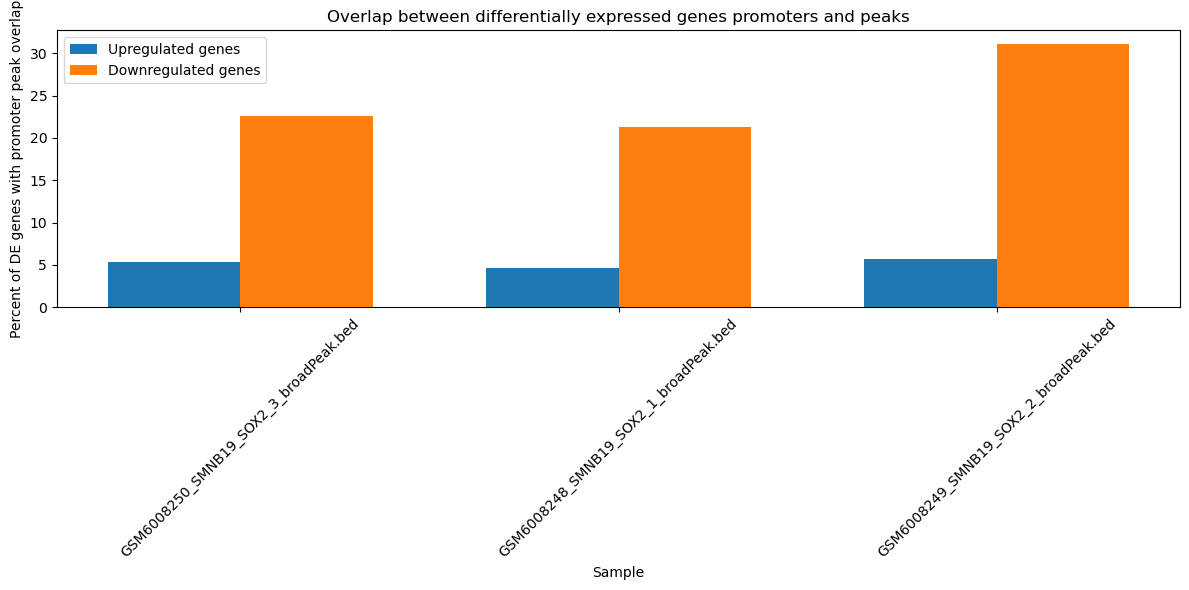

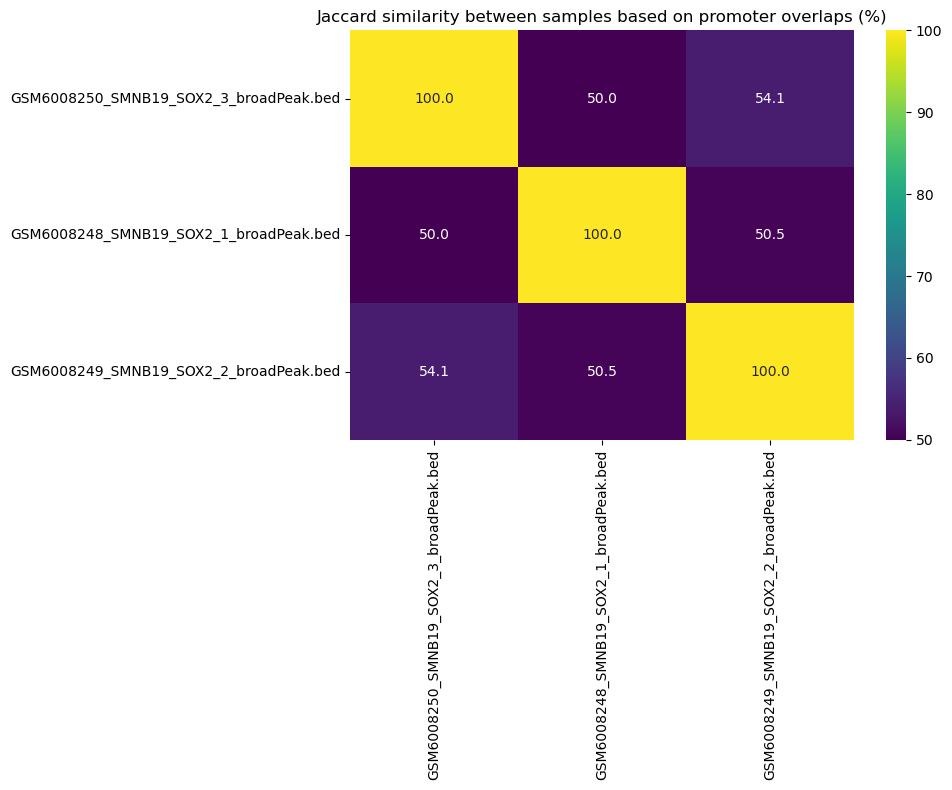

In [13]:
# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Prepare data for plotting
samples = list(summary.keys())
up_percents = [summary[s]['up_percent'] for s in samples]
down_percents = [summary[s]['down_percent'] for s in samples]

# Create bar plot
plt.figure(figsize=(12, 6))
x = np.arange(len(samples))
width = 0.35

plt.bar(x - width/2, up_percents, width, label='Upregulated genes')
plt.bar(x + width/2, down_percents, width, label='Downregulated genes')

plt.xlabel('Sample')
plt.ylabel('Percent of DE genes with promoter peak overlap')
plt.title('Overlap between differentially expressed genes promoters and peaks')
plt.xticks(x, samples, rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

# Create heatmap for sample comparison
overlap_matrix = np.zeros((len(samples), len(samples)))
for i, sample1 in enumerate(samples):
    for j, sample2 in enumerate(samples):
        if i == j:
            overlap_matrix[i, j] = 100
        else:
            genes1 = set(summary[sample1]['up_gene_list'] + summary[sample1]['down_gene_list'])
            genes2 = set(summary[sample2]['up_gene_list'] + summary[sample2]['down_gene_list'])
            
            if len(genes1) > 0 and len(genes2) > 0:
                overlap = len(genes1.intersection(genes2))
                union = len(genes1.union(genes2))
                overlap_matrix[i, j] = overlap / union * 100

plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix, annot=True, fmt='.1f', cmap='viridis',
            xticklabels=samples, yticklabels=samples)
plt.title('Jaccard similarity between samples based on promoter overlaps (%)')
plt.tight_layout()

plt.show()

In [14]:
print(f"Saving results to {output_dir}")

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Save summary as CSV
summary_df = pd.DataFrame({
    'Sample': [],
    'Upregulated_Overlaps': [],
    'Upregulated_Total': [],
    'Upregulated_Percent': [],
    'Downregulated_Overlaps': [],
    'Downregulated_Total': [],
    'Downregulated_Percent': []
})

for sample, data in summary.items():
    summary_df = pd.concat([summary_df, pd.DataFrame({
        'Sample': [sample],
        'Upregulated_Overlaps': [data['up_overlaps']],
        'Upregulated_Total': [data['up_genes']],
        'Upregulated_Percent': [data['up_percent']],
        'Downregulated_Overlaps': [data['down_overlaps']],
        'Downregulated_Total': [data['down_genes']],
        'Downregulated_Percent': [data['down_percent']]
    })], ignore_index=True)

summary_df.to_csv(os.path.join(output_dir, 'promoter_overlap_summary.csv'), index=False)

# Save overlapping gene lists
for sample, data in summary.items():
    with open(os.path.join(output_dir, f'{sample}_up_promoter_overlapping_genes.txt'), 'w') as f:
        for gene in data['up_gene_list']:
            f.write(f"{gene}\n")
    
    with open(os.path.join(output_dir, f'{sample}_down_promoter_overlapping_genes.txt'), 'w') as f:
        for gene in data['down_gene_list']:
            f.write(f"{gene}\n")

Saving results to /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_H2AK119Ub_cross_V5/SRF_RNA/results/overlap_SOX2
